In [1]:
import sys

!{sys.executable} -m pip install --quiet matplotlib numpy scikit-learn

In [2]:
import torch
import torch.nn as nn
from typing import Tuple

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CharLSTM(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_size: int, n_layers: int, dropout: float):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0.0,
            batch_first=True,
        )
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def init_hidden(self, batch_size: int, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
        h = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)
        c = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)
        return h, c

    def forward(self, x: torch.Tensor, hc: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        emb = self.embedding(x)
        out, (h, c) = self.lstm(emb, hc)
        out = self.drop(out)
        logits = self.fc(out)
        return logits, (h, c)

In [3]:
# Charger le modèle (LSTM_models/best_lstm_model.pt si utilisation en local)
ckpt = torch.load("best_lstm_model.pt", map_location=device)

config = ckpt["config"]
char2idx = ckpt["char2int"]
vocab_size = ckpt["vocab_size"]

model = CharLSTM(
    vocab_size=vocab_size,
    embedding_dim=config["embedding_dim"],
    hidden_size=config["hidden_size"],
    n_layers=config["n_layers"],
    dropout=config["dropout"],
).to(device)

model.load_state_dict(ckpt["model_state_dict"])
model.eval()

print("r2_local:", ckpt.get("r2_local"))
print("best_neuron:", ckpt.get("best_neuron"))
print("device:", next(model.parameters()).device)

BEST_NEURON = int(ckpt.get('best_neuron', 250))
print('best_neuron:', BEST_NEURON)

r2_local: 0.7363255060077168
best_neuron: 250
device: cpu
best_neuron: 250


In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def encode_string(s, char2idx):
    return torch.tensor(
        [char2idx[c] for c in s if c in char2idx],
        dtype=torch.long
    )

In [6]:
def extract_c_neuron(model, s, char2idx, neuron_idx=None, device=device):
    """Retourne l’état de cellule de la dernière couche c_{t,neuron_idx} au cours du temps pour une chaîne donnée."""
    if neuron_idx is None:
        neuron_idx = BEST_NEURON
    
    x = encode_string(s, char2idx).unsqueeze(0).to(device)
    emb = model.embedding(x)

    hx = torch.zeros(model.n_layers, 1, model.hidden_size, device=device)
    cx = torch.zeros(model.n_layers, 1, model.hidden_size, device=device)

    c_vals = []
    for t in range(emb.size(1)):
        _, (hx, cx) = model.lstm(emb[:, t:t+1, :], (hx, cx))
        c_vals.append(cx[-1, 0, neuron_idx].item())

    return np.array(c_vals)

In [7]:
s_paren = "abc (def ghi) jkl"
s_brack = "abc [def ghi] jkl"

c_paren = extract_c_neuron(model, s_paren, char2idx)
c_brack = extract_c_neuron(model, s_brack, char2idx)

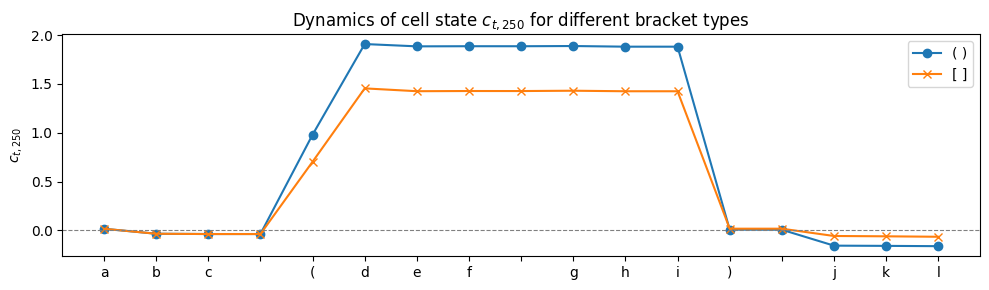

In [8]:
plt.figure(figsize=(10, 3))

plt.plot(c_paren, label="( )", marker="o")
plt.plot(c_brack, label="[ ]", marker="x")

plt.xticks(range(len(s_paren)), list(s_paren))
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)

plt.ylabel(r"$c_{t,250}$")
plt.title("Dynamics of cell state $c_{t,250}$ for different bracket types")
plt.legend()
plt.tight_layout()
plt.show()

## Ablations : le neurone 250 n’est pas un simple marqueur

Nous effectuons des interventions au moment de l’inférence sur l’état de cellule du LSTM $c_t$:
- Lésion : forcer $c_{t,250}=0$ à chaque pas de temps (et comparer à des lésions aléatoires).
- Clamp : forcer $c_{t,250}=K$ (toujours « à l’intérieur ») ou $0$ (toujours « à l’extérieur »).

Nous mesurons ensuite la quantité d’information restante concernant le label inside-parentheses, à l’aide d’une linear probe appliquée à l’ensemble des neurones (représentation distribuée) ainsi qu’au neurone individuel (représentation locale).

In [9]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', message='.*Ill-conditioned.*')
warnings.filterwarnings('ignore', message='.*singular.*')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import random

In [10]:
PROBE_ALPHA = 10.0  # α=10 comme indiqué dans le rapport

def inside_parentheses_labels(s: str, open_char='(', close_char=')'):
    """
	Étiquette binaire pour chaque caractère : 1 s’il est à l’intérieur des délimiteurs, 0 sinon.
	Convention : les délimiteurs eux-mêmes sont étiquetés comme à l’extérieur (0).
    """
    depth = 0
    y = []
    for ch in s:
        if ch == open_char:
            y.append(0)  # '(' itself is outside
            depth += 1
        elif ch == close_char:
            depth = max(0, depth - 1)
            y.append(0)  # ')' itself is outside
        else:
            y.append(1 if depth > 0 else 0)
    return y

def make_synthetic_strings(n=2000, min_len=20, max_len=80, bracket_type='()', 
                           allow_nested=True, allow_multiple=True):
    """
	Génère des chaînes contenant des délimiteurs. Amélioré pour inclure :
	– des délimiteurs imbriqués : ((...))
	– plusieurs paires : (...) (...)
	– des paires simples uniques
    """
    if bracket_type == '()':
        open_b, close_b = '(', ')'
    elif bracket_type == '[]':
        open_b, close_b = '[', ']'
    else:
        raise ValueError("bracket_type must be '()' or '[]'")

    alphabet = [c for c in char2idx.keys() if c.isalpha()]
    if not alphabet:
        alphabet = [c for c in char2idx.keys() if c not in ['(',')','[',']','\\n','\\t','\\r']]
    if ' ' in char2idx:
        alphabet = alphabet + [' ']

    def random_text(length):
        return ''.join(random.choice(alphabet) for _ in range(length))

    out = []
    for i in range(n):
        L = random.randint(min_len, max_len)
        mode = random.choice(['simple', 'nested', 'multiple'] if (allow_nested and allow_multiple) 
                             else ['simple'])
        
        if mode == 'simple':
            # text ( text ) text
            span_len = random.randint(3, max(3, L//3))
            pre_len = random.randint(1, max(1, L - span_len - 2))
            post_len = max(0, L - pre_len - span_len - 2)
            s = random_text(pre_len) + open_b + random_text(span_len) + close_b + random_text(post_len)
        
        elif mode == 'nested':
            # text (( text )) text
            inner_len = random.randint(2, max(2, L//4))
            outer_len = random.randint(1, max(1, L//6))
            pre_len = random.randint(1, max(1, L//4))
            post_len = max(0, L - pre_len - inner_len - outer_len*2 - 4)
            s = (random_text(pre_len) + open_b + random_text(outer_len) + 
                 open_b + random_text(inner_len) + close_b + 
                 random_text(outer_len) + close_b + random_text(post_len))
        
        elif mode == 'multiple':
            # text ( text ) text ( text ) text
            span1 = random.randint(2, max(2, L//5))
            span2 = random.randint(2, max(2, L//5))
            pre = random.randint(1, max(1, L//5))
            mid = random.randint(1, max(1, L//5))
            post = max(0, L - pre - mid - span1 - span2 - 4)
            s = (random_text(pre) + open_b + random_text(span1) + close_b +
                 random_text(mid) + open_b + random_text(span2) + close_b + random_text(post))
        
        out.append(s)
    return out

def extract_ct_features(model, s: str, char2idx, device=device, intervention=None):
    """
	Retourne (X, y) où chaque time-step correspond à un échantillon :
    X_t = c_t (hidden_size), y_t = inside label.
    """
    s2 = ''.join([ch for ch in s if ch in char2idx])
    x = encode_string(s2, char2idx).unsqueeze(0).to(device)
    emb = model.embedding(x)

    hx = torch.zeros(model.n_layers, 1, model.hidden_size, device=device)
    cx = torch.zeros(model.n_layers, 1, model.hidden_size, device=device)

    feats = []
    for t in range(emb.size(1)):
        _, (hx, cx) = model.lstm(emb[:, t:t+1, :], (hx, cx))
        if intervention is not None:
            cx = intervention(cx, t)
        feats.append(cx[-1, 0, :].detach().float().cpu().numpy())

    y = np.array(inside_parentheses_labels(s2, '(', ')'), dtype=np.float32)
    X = np.stack(feats, axis=0)
    return X, y

def build_probe_matrix(strings, model, char2idx, device=device, intervention=None):
    Xs, ys = [], []
    for s in strings:
        X, y = extract_ct_features(model, s, char2idx, device=device, intervention=intervention)
        Xs.append(X)
        ys.append(y)
    return np.concatenate(Xs, axis=0), np.concatenate(ys, axis=0)

def eval_probes(X, y, neuron_idx=250, seed=10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Probe distribuée : régression linéaire sur l’ensemble des neurones
    lr_all = make_pipeline(StandardScaler(), Ridge(alpha=PROBE_ALPHA))
    lr_all.fit(X_train, y_train)
    y_pred_all = lr_all.predict(X_test)
    r2_all = r2_score(y_test, y_pred_all)

    # Probe locale : neurone unique
    lr_one = make_pipeline(StandardScaler(), Ridge(alpha=PROBE_ALPHA))
    lr_one.fit(X_train[:, [neuron_idx]], y_train)
    y_pred_one = lr_one.predict(X_test[:, [neuron_idx]])
    r2_one = r2_score(y_test, y_pred_one)

    return r2_one, r2_all

Generating synthetic strings (simple + nested + multiple)...

Examples:
  'yaivHςFWκ zpaEErXmZtιAIAZQdAbzοXp(eYuaLtpνœιοoihOq...'
  'næιwSOdμTονYnux(ZcKδOQdfyFM)ExjyZREZY'
  'DeMsθ(JFWδGςνI)jOæδnlYeα'

Building baseline probe matrix...
  X shape: (98951, 512), y mean (inside ratio): 0.252

Baseline   R² local(250): 0.4583 | R² distributed: 0.6569

LESION EXPERIMENT: forcing neuron 250 = 0
Lesion     R² local(250): -0.0000 | R² distributed: 0.5815

Drop in local R²:       0.4583
Drop in distributed R²: 0.0754

Comparing to random neuron lesions...

Random lesion R² drops (n=20):
  Local:       mean=0.0003, std=0.0018
  Distributed: mean=0.0003, std=0.0008

Neuron 250 lesion drop: local=0.4583, dist=0.0754


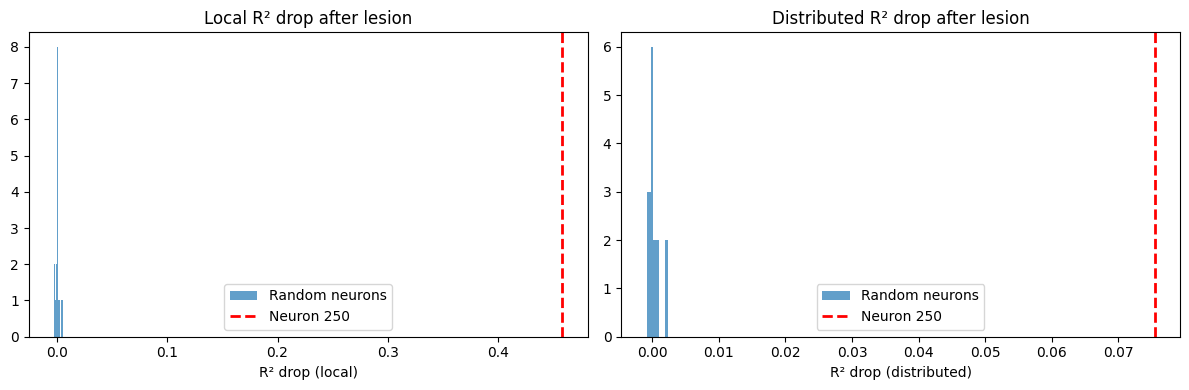

In [11]:
# Construire un petit probe set synthétique (rapide, sans ré-entraînement)
print("Generating synthetic strings (simple + nested + multiple)...")
strings = make_synthetic_strings(n=2000, bracket_type='()', allow_nested=True, allow_multiple=True)

# Exemples
print("\nExamples:")
for s in strings[:3]:
    print(f"  '{s[:50]}...'" if len(s) > 50 else f"  '{s}'")

print("\nBuilding baseline probe matrix...")
X_base, y_base = build_probe_matrix(strings, model, char2idx, intervention=None)
print(f"  X shape: {X_base.shape}, y mean (inside ratio): {y_base.mean():.3f}")

r2_one_base, r2_all_base = eval_probes(X_base, y_base, neuron_idx=BEST_NEURON)
print(f"\nBaseline   R² local({BEST_NEURON}): {r2_one_base:.4f} | R² distributed: {r2_all_base:.4f}")

# Lesion experiment 
def lesion_intervention_factory(idx):
    """Force neuron idx to 0 at every timestep."""
    def _intervene(cx, t):
        cx = cx.clone()
        cx[-1, :, idx] = 0.0  # Fixed: only last layer
        return cx
    return _intervene

print("\n" + "="*50)
print(f"LESION EXPERIMENT: forcing neuron {BEST_NEURON} = 0")
print("="*50)

X_les, y_les = build_probe_matrix(strings, model, char2idx, intervention=lesion_intervention_factory(BEST_NEURON))
r2_one_les, r2_all_les = eval_probes(X_les, y_les, neuron_idx=BEST_NEURON)
print(f"Lesion     R² local({BEST_NEURON}): {r2_one_les:.4f} | R² distributed: {r2_all_les:.4f}")
print(f"\nDrop in local R²:       {r2_one_base - r2_one_les:.4f}")
print(f"Drop in distributed R²: {r2_all_base - r2_all_les:.4f}")

print("\nComparing to random neuron lesions...")
random.seed(0)
candidates = [i for i in range(model.hidden_size) if i != BEST_NEURON]
rand_idxs = random.sample(candidates, 20)

drops_local = []
drops_dist = []
for j in rand_idxs:
    X_j, y_j = build_probe_matrix(strings, model, char2idx, intervention=lesion_intervention_factory(j))
    r2_one_j, r2_all_j = eval_probes(X_j, y_j, neuron_idx=BEST_NEURON)
    drops_local.append(r2_one_base - r2_one_j)
    drops_dist.append(r2_all_base - r2_all_j)

print(f"\nRandom lesion R² drops (n=20):")
print(f"  Local:       mean={np.mean(drops_local):.4f}, std={np.std(drops_local):.4f}")
print(f"  Distributed: mean={np.mean(drops_dist):.4f}, std={np.std(drops_dist):.4f}")
print(f"\nNeuron {BEST_NEURON} lesion drop: local={r2_one_base - r2_one_les:.4f}, dist={r2_all_base - r2_all_les:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(drops_local, bins=10, alpha=0.7, label='Random neurons')
axes[0].axvline(r2_one_base - r2_one_les, color='red', linestyle='--', linewidth=2, label=f'Neuron {BEST_NEURON}')
axes[0].set_xlabel('R² drop (local)')
axes[0].set_title('Local R² drop after lesion')
axes[0].legend()

axes[1].hist(drops_dist, bins=10, alpha=0.7, label='Random neurons')
axes[1].axvline(r2_all_base - r2_all_les, color='red', linestyle='--', linewidth=2, label=f'Neuron {BEST_NEURON}')
axes[1].set_xlabel('R² drop (distributed)')
axes[1].set_title('Distributed R² drop after lesion')
axes[1].legend()

plt.tight_layout()
plt.show()

Clamp K (typical 'inside' value) = 1.889

CLAMP EXPERIMENTS

Clamp neuron 250 = 0 (always 'outside')...
Clamp=0    R² local(250): -0.0000 | R² distributed: 0.5815

Clamp neuron 250 = 1.89 (always 'inside')...
Clamp=K    R² local(250): -0.0000 | R² distributed: 0.5731

SUMMARY
Condition            R² local     R² distributed 
--------------------------------------------------
Baseline             0.4583       0.6569         
Lesion (=0)          -0.0000      0.5815         
Clamp=0              -0.0000      0.5815         
Clamp=K              -0.0000      0.5731         


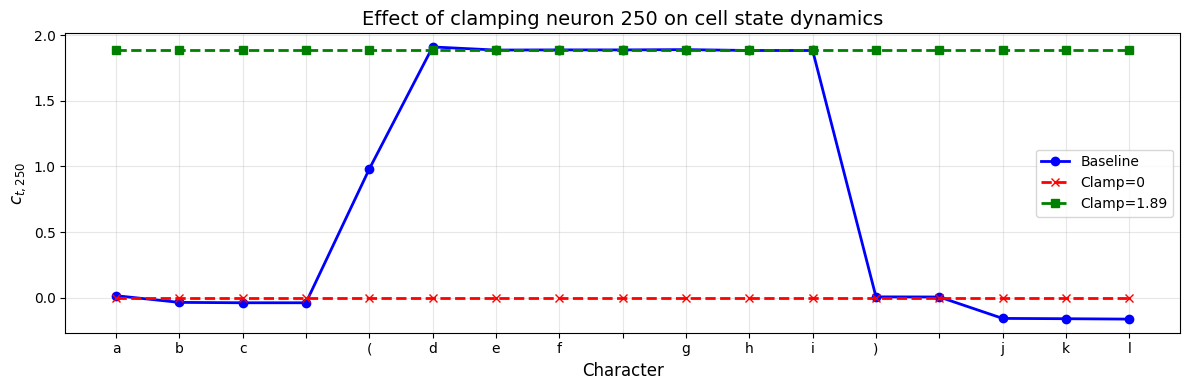

In [12]:
# Estimer une valeur raisonnable de contrainte K correspondant à l’état "à l’intérieur"
# à partir de l’exécution précédente sur les parenthèses (plateau observé entre '(' et ')')

paren_positions = [i for i, ch in enumerate(s_paren) if ch in ['(', ')']]
if len(paren_positions) >= 2:
    start = paren_positions[0] + 1
    end = paren_positions[1]
    K = float(np.mean(c_paren[start:end]))
else:
    K = 1.5
print(f"Clamp K (typical 'inside' value) = {K:.3f}")

def clamp_intervention_factory(idx, value):
    """Force neuron idx to a fixed value at every timestep (last layer only)."""
    def _intervene(cx, t):
        cx = cx.clone()
        cx[-1, :, idx] = float(value)  # Fixed: only last layer [-1]
        return cx
    return _intervene

print("\n" + "="*50)
print("CLAMP EXPERIMENTS")
print("="*50)

# Clamp always outside (0)
print(f"\nClamp neuron {BEST_NEURON} = 0 (always 'outside')...")
X_c0, y_c0 = build_probe_matrix(strings, model, char2idx, intervention=clamp_intervention_factory(BEST_NEURON, 0.0))
r2_one_c0, r2_all_c0 = eval_probes(X_c0, y_c0, neuron_idx=BEST_NEURON)
print(f"Clamp=0    R² local({BEST_NEURON}): {r2_one_c0:.4f} | R² distributed: {r2_all_c0:.4f}")

# Clamp always inside (K)
print(f"\nClamp neuron {BEST_NEURON} = {K:.2f} (always 'inside')...")
X_cK, y_cK = build_probe_matrix(strings, model, char2idx, intervention=clamp_intervention_factory(BEST_NEURON, K))
r2_one_cK, r2_all_cK = eval_probes(X_cK, y_cK, neuron_idx=BEST_NEURON)
print(f"Clamp=K    R² local({BEST_NEURON}): {r2_one_cK:.4f} | R² distributed: {r2_all_cK:.4f}")

# Tableau récap
print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"{'Condition':<20} {'R² local':<12} {'R² distributed':<15}")
print("-"*50)
print(f"{'Baseline':<20} {r2_one_base:<12.4f} {r2_all_base:<15.4f}")
print(f"{'Lesion (=0)':<20} {r2_one_les:<12.4f} {r2_all_les:<15.4f}")
print(f"{'Clamp=0':<20} {r2_one_c0:<12.4f} {r2_all_c0:<15.4f}")
print(f"{'Clamp=K':<20} {r2_one_cK:<12.4f} {r2_all_cK:<15.4f}")
print("="*50)

# Visualiser c250 sur des chaînes contrôlées sous clamp
def extract_c250_with_intervention(s, intervention):
    x = encode_string(s, char2idx).unsqueeze(0).to(device)
    emb = model.embedding(x)
    hx = torch.zeros(model.n_layers, 1, model.hidden_size, device=device)
    cx = torch.zeros(model.n_layers, 1, model.hidden_size, device=device)
    vals = []
    for t in range(emb.size(1)):
        _, (hx, cx) = model.lstm(emb[:, t:t+1, :], (hx, cx))
        cx = intervention(cx, t)
        vals.append(cx[-1, 0, BEST_NEURON].item())
    return vals

c_paren_clamp0 = extract_c250_with_intervention(s_paren, clamp_intervention_factory(BEST_NEURON, 0.0))
c_paren_clampK = extract_c250_with_intervention(s_paren, clamp_intervention_factory(BEST_NEURON, K))

plt.figure(figsize=(12, 4))
plt.plot(c_paren, 'b-o', label="Baseline", linewidth=2, markersize=6)
plt.plot(c_paren_clamp0, 'r--x', label="Clamp=0", linewidth=2, markersize=6)
plt.plot(c_paren_clampK, 'g--s', label=f"Clamp={K:.2f}", linewidth=2, markersize=6)
plt.xticks(range(len(s_paren)), list(s_paren), fontsize=10)
plt.ylabel(r"$c_{t,250}$", fontsize=12)
plt.xlabel("Character", fontsize=12)
plt.title(f"Effect of clamping neuron {BEST_NEURON} on cell state dynamics", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
# Le neurone 250 encode-t-il la profondeur?

def get_depth_labels(s):
    """Retourne la profondeur à chaque position."""
    depth = 0
    depths = []
    for ch in s:
        if ch == '(':
            depth += 1
            depths.append(depth)
        elif ch == ')':
            depths.append(depth)
            depth = max(0, depth - 1)
        else:
            depths.append(depth)
    return depths

# Test avec différentes profondeurs
test_strings = [
    "abc (def) ghi",
    "abc ((def)) ghi",
    "abc (((def))) ghi",
    "abc ((((def)))) ghi",
]

print("Activation moyenne par profondeur:")
for s in test_strings:
    acts = extract_c_neuron(model, s, char2idx)
    depths = get_depth_labels(s)
    filtered_s = ''.join([c for c in s if c in char2idx])
    
    # Moyenne des activations pour chaque niveau
    for d in sorted(set(depths)):
        if d > 0:
            mask = [i for i, x in enumerate(depths) if x == d]
            mean_act = np.mean([acts[i] for i in mask])
            print(f"  '{s[:20]}...' depth={d}: mean_activation={mean_act:.3f}")

# Corrélation globale
from scipy.stats import pearsonr
all_acts, all_depths = [], []
for s in test_strings:
    acts = extract_c_neuron(model, s, char2idx)
    depths = get_depth_labels(s)
    for a, d in zip(acts, depths):
        if d > 0:
            all_acts.append(a)
            all_depths.append(d)

r, p = pearsonr(all_acts, all_depths)
print(f"\nCorrélation activation vs depth: r={r:.3f}, p={p:.4f}")

Activation moyenne par profondeur:
  'abc (def) ghi...' depth=1: mean_activation=1.334
  'abc ((def)) ghi...' depth=1: mean_activation=0.490
  'abc ((def)) ghi...' depth=2: mean_activation=1.381
  'abc (((def))) ghi...' depth=1: mean_activation=0.491
  'abc (((def))) ghi...' depth=2: mean_activation=0.501
  'abc (((def))) ghi...' depth=3: mean_activation=1.350
  'abc ((((def)))) ghi...' depth=1: mean_activation=0.491
  'abc ((((def)))) ghi...' depth=2: mean_activation=0.501
  'abc ((((def)))) ghi...' depth=3: mean_activation=0.500
  'abc ((((def)))) ghi...' depth=4: mean_activation=1.310

Corrélation activation vs depth: r=0.188, p=0.3024
